In [1]:
import os
import pandas as pd

from pprint import pprint

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from pytorch_lightning import LightningModule, Trainer, seed_everything

from transformers import BertForSequenceClassification, BertTokenizer, AdamW

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import re
import emoji
from soynlp.normalizer import repeat_normalize

In [2]:
MODEL_NAME= "beomi/kcbert-base"
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

In [3]:
import pandas as pd
data_path ='C:/Users/USER/Desktop/2021_korean_hate_speech_detection/hs_CORAL/dataset/'
koco_train_df = pd.read_csv(data_path+"koco_gender_train.txt", sep="\t")
koco_test_df = pd.read_csv(data_path+"koco_gender_test.txt", sep="\t")
koco_train_df.head(5)

,comments,bias
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,1
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,0
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",0
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",0
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,2


In [4]:
def preprocess_dataframe(df):
    pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-힣]+')
    url_pattern = re.compile(
        r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

    def clean(x):
        x = pattern.sub(' ', x)
        x = url_pattern.sub('', x)
        x = x.strip()
        x = repeat_normalize(x, num_repeats=2)
        return x
    for i in range(len(df)):
        df['comments'][i] == clean(str(df['comments'][i]))

    return df

In [5]:
koco_prep_train_df = preprocess_dataframe(koco_train_df)
koco_prep_test_df = preprocess_dataframe(koco_test_df)

In [6]:
tokenized_train_sentences = tokenizer(
                            list(koco_prep_train_df['comments']),
                            return_tensors="pt",
                            max_length=64,
                            padding=True,
                            truncation=True,
                            add_special_tokens=True)

tokenized_test_sentences = tokenizer(
                            list(koco_prep_test_df['comments']),
                            return_tensors="pt",
                            max_length=64,
                            padding=True,
                            truncation=True,
                            add_special_tokens=True)

In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

In [8]:
train_label = koco_train_df["bias"].values
test_label =  koco_test_df["bias"].values

train_dataset = MyDataset(tokenized_train_sentences, train_label)
test_dataset = MyDataset(tokenized_test_sentences, test_label)

In [9]:
print(torch.tensor(koco_test_df["bias"].values))

tensor([0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2,
        0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0,
        0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0,
        0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0,
        0, 0, 0, 2, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0,
        0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0,
        0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2,
        0, 0, 2, 0, 0, 0, 1, 2, 2, 0, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0,
        1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 1, 2,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,

In [10]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/output/', # 학습결과 저장경로
    num_train_epochs=10,                # 학습 epoch 설정
    per_device_train_batch_size=4,      # train batch_size 설정
    per_device_eval_batch_size=32,      # test batch_size 설정
    logging_dir='C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/logs/',# 학습log 저장경로
    logging_steps=500,                  # 학습log 기록 단위
    save_total_limit=2,                 # 학습결과 저장 최대갯수 
)

In [11]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [12]:
from transformers import Trainer
#model_path = 'C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/output/pytorch_model.bin'
#model.load_state_dict(torch.load(model_path))
trainer = Trainer(
    model=model,                         # 학습하고자하는 🤗 Transformers model
    args=training_args,                  # 위에서 정의한 Training Arguments
    train_dataset=train_dataset,         # 학습 데이터셋
    eval_dataset=test_dataset,           # 평가 데이터셋
    compute_metrics=compute_metrics,     # 평가지표
)

In [13]:
trainer.train()

***** Running training *****
  Num examples = 7896
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 19740
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Step,Training Loss
500,0.800000
1000,0.763300
1500,0.765500
2000,0.769600
2500,0.738600
3000,0.783100
3500,0.734000
4000,0.720000
4500,0.684600
5000,0.681800


Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/output/checkpoint-500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/output/checkpoint-500\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/output/checkpoint-500\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcBERT_outputs\output\checkpoint-19000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requi

Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/output/checkpoint-4500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/output/checkpoint-4500\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/output/checkpoint-4500\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcBERT_outputs\output\checkpoint-3500] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().req

Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/output/checkpoint-8500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/output/checkpoint-8500\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/output/checkpoint-8500\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcBERT_outputs\output\checkpoint-7500] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().req

Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/output/checkpoint-12500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/output/checkpoint-12500\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/output/checkpoint-12500\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcBERT_outputs\output\checkpoint-11500] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach()

Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/output/checkpoint-16500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/output/checkpoint-16500\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/output/checkpoint-16500\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KcBERT_outputs\output\checkpoint-15500] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach()

TrainOutput(global_step=19740, training_loss=0.561070341904475, metrics={'train_runtime': 1357.0644, 'train_samples_per_second': 58.184, 'train_steps_per_second': 14.546, 'total_flos': 2596929432975360.0, 'train_loss': 0.561070341904475, 'epoch': 10.0})

In [14]:
trainer.evaluate(eval_dataset=test_dataset)

***** Running Evaluation *****
  Num examples = 471
  Batch size = 32
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


{'eval_loss': 1.1776981353759766,
 'eval_accuracy': 0.7876857749469215,
 'eval_f1': 0.6984227275991982,
 'eval_precision': 0.7000759744738222,
 'eval_recall': 0.7128838921784212,
 'eval_runtime': 0.4129,
 'eval_samples_per_second': 1140.742,
 'eval_steps_per_second': 36.329,
 'epoch': 10.0}

In [15]:
trainer.save_model()

Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/output/
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/output/config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KcBERT_outputs/output/pytorch_model.bin


In [16]:
predictions = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 471
  Batch size = 32
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


              precision    recall  f1-score   support

           0       0.89      0.84      0.87       342
           1       0.41      0.61      0.49        62
           2       0.79      0.69      0.74        67

    accuracy                           0.79       471
   macro avg       0.70      0.71      0.70       471
weighted avg       0.82      0.79      0.80       471



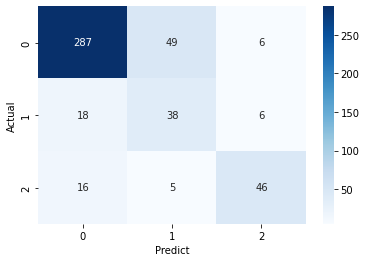

In [17]:
## classification_report
from sklearn.metrics import classification_report
y_test = test_dataset.labels
preds_list = predictions[0].argmax(-1)
clf_report = classification_report(y_test, preds_list)
print(clf_report)

# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, preds_list)

# 오차행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [18]:
from coral_pytorch.dataset import proba_to_label

def compute_mae_and_mse(label, preds_list):

    mae, mse = 0., 0.
    num_examples = len(label)
    targets = torch.tensor(label)
    predicted_labels = torch.tensor(preds_list)
    
    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

    mae = mae / num_examples
    mse = mse / num_examples
    return mae, mse

In [19]:
mae, mse = compute_mae_and_mse(y_test, preds_list)
print(mae)
print(mse)

tensor(0.2590)
tensor(0.3524)


C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
